# Random pattern generator

Generate a random pattern using group theory.

Tech 411.05 *Patterns and Symmetry*, University of New Hampsire, J. Gibson, 2024-10-11

## Define helpful functions

### function dihedralgroup(n, withflip=true)

This function generates the matrices that rotate and flip an n-gon in the plane,
for a given value of n. An n-gon will have 2n such matrices: n rotations, and
those rotations reflected about the y axis. You can exclude the flips by setting 
the second argument to 'false'.

In [1]:
using LinearAlgebra, Plots

rotation(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]

# Generate symmetries of the n-gon with or without flip, represented 
# by the matrices that rotate and flip the n-gon in the plane
function dihedralgroup(n, withflip=true)
    S = [-1 0; 0 1]                 # a reflection about y axis
    I = [1.0 0.0; 0.0 1.0]          # the identity
    Dn = fill(I, withflip ? 2n : n) # allocate an array of 2n or n matrices
    
    for k=1:n
        Rk = rotation(2(k-1)π/n)
        Dn[k]   = Rk
        if withflip
            Dn[k+n] = S*Rk
        end
    end
    Dn
end

dihedralgroup (generic function with 2 methods)

For example, here's the symmetry group of the 4-gon, i.e. the square,
represented as 8 2x2 matrices. The printout is somewhat obscured by
numbers that are close to but not exactly zero. 

In [2]:
D4 = dihedralgroup(4)

8-element Vector{Matrix{Float64}}:
 [1.0 -0.0; 0.0 1.0]
 [6.123233995736766e-17 -1.0; 1.0 6.123233995736766e-17]
 [-1.0 -1.2246467991473532e-16; 1.2246467991473532e-16 -1.0]
 [-1.8369701987210297e-16 1.0; -1.0 -1.8369701987210297e-16]
 [-1.0 0.0; 0.0 1.0]
 [-6.123233995736766e-17 1.0; 1.0 6.123233995736766e-17]
 [1.0 1.2246467991473532e-16; 1.2246467991473532e-16 -1.0]
 [1.8369701987210297e-16 -1.0; -1.0 -1.8369701987210297e-16]

To get the 3rd matrix in this group, access it using `D4[3]`

In [3]:
D4[3]

2×2 Matrix{Float64}:
 -1.0          -1.22465e-16
  1.22465e-16  -1.0

### symmetrize(X,G)

This function takes a set of $(x_j, y_j)$ data points, stored in a $2 \times n$ matrix 
of the form

\begin{align*}
X = \begin{bmatrix}x_1 & x_2 & x_3 & \ldots \\ y_1 & y_2 & y_3 & \ldots \end{bmatrix}
\end{align*}

and a set of symmetries $G = G[1], G[2], \ldots$. For example, $G$ might be the dihedral group $D_4$.

The function maps each data point $x = (x_j, y_j)$ through each symmetry $G[k]$ and returns 
set of all mapped data points in the matrix $GX$.

In [4]:
# Symmetrize a set of data points X by symmetry group G
function symmetrize(X, G)
    m,nX = size(X)  # nX is number of data points
    nG = length(G)  # nG is number elements in group
    
    GX = fill(0.0, 2, nX*nG) # allocate a matrix for G applied to X
    
    for j in 1:nX      # for each point in X
        for k in 1:nG  # and for each matrix in the group
            GX[:, (j-1)*nG + k] = G[k]*X[:,j] # map the jth datapoint by the kth matrix
        end
    end
    GX
end

symmetrize (generic function with 1 method)

Let's observe how that works. First set up an $X$ matrix with three 
random data points.

In [5]:
X = randn(2,3)

2×3 Matrix{Float64}:
 -0.931209  -1.52169   0.669649
 -2.222     -0.144243  0.512084

A plot of these these data points.

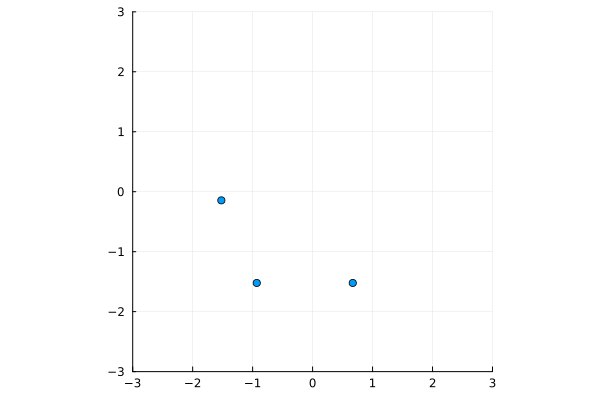

In [6]:
p1 = scatter(X[1,:], X[:,2], aspect_ratio=1, label="", xlim=(-3,3), ylim=(-3,3))

Now apply all the symmetries of the square ($D_4$) to $X$ and replot.
I'll label the output `Xsymm`, standing for X symmetrixed. Three data points
times 8 symmetries produces 24 symmetrized data points.

In [7]:
Xsymm = symmetrize(X,D4)

2×24 Matrix{Float64}:
 -0.931209   2.222     0.931209  -2.222     …  0.512084   0.669649  -0.512084
 -2.222     -0.931209  2.222      0.931209     0.669649  -0.512084  -0.669649

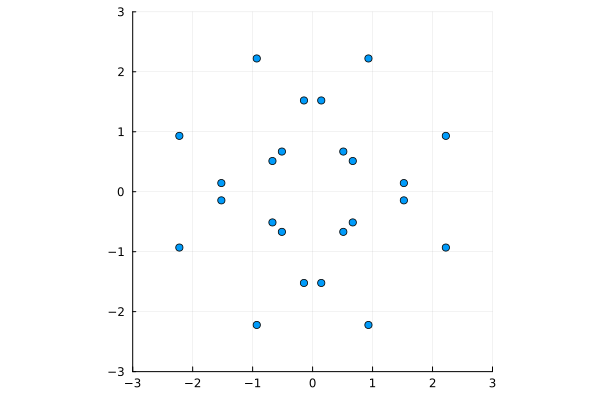

In [8]:
p2 = scatter(Xsymm[1,:], Xsymm[2,:], aspect_ratio=1, label="", xlim=(-3,3), ylim=(-3,3))

By mapping all the random data points through all the symmetries of the square, 
we have made a set of random data points with the symmetries of the square!

### A function to color the plane based on distance to the data points. 

The following function assigns a numerical value $z = f(x)$ to every 2d point
$x$ in the plane. 

\begin{align*}
f(x) = \sum_{j=1}^n \cos(k\|x-x_j\|) \; e^{-a \|x-x_j\|^2}
\end{align*}

Here $x = (x_1, x_2)$ is a point in the plane, $x_k$ is also a point in the plane, 
and $\|x-x_k\|$ is the distance between the points.

The Julia function for `f` has a few extra parameters, `Xsymm` for the data points
and `a` and `k` to specify the scale of oscillations in the cosine and the decay rate
in the exponential. 

In [9]:
function f(x, Xsymm, a=1, k=1)
    s = 0.0
    for j in 1:size(Xsymm, 2)
        r = norm(x-Xsymm[:,j])
        s += cos(k*r)*exp(-a*(r^2))
    end
    s
end

f (generic function with 3 methods)

#### f(x) in one dimension

The function $f(x)$ is probably best understood through plotting. Let's start with
the one-dimensional version with data points X at just the origin. In this case, 
$f(x)$ reduces to

\begin{align*}
f(x) = \cos(kx) \; e^{-a x^2}
\end{align*}

$f(x)$ is a bell curve (Gaussian distribution) $e^{-a x^2}$ modulated by an oscillation $\cos(kx)$. 

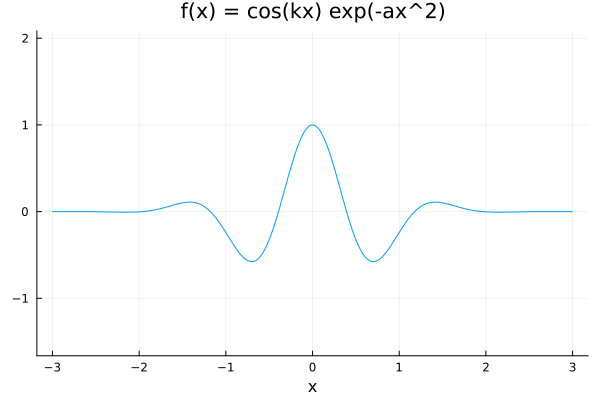

In [13]:
# define and plot a 1d version of f(x)

a = 1
k = 4

f(x, a, k) = cos(k*x)*exp(-a*x^2)

x = range(-3,3, 256)

plot(x, f.(x,a,k), aspect_ratio=1, title="f(x) = cos(kx) exp(-ax^2)", label="", xlabel="x")


**Activity:** Try playing around with the values of $a$ and $k$ and replotting.
You should see that parameter $a$ controls how quickly the shape tapers to zero
towards the edges, and $k$ controls how rapidly the curve oscillates up and down
as $|x|$ increases.

#### f(x) in two dimensions

The two-dimensional version of $f(x)$ is just the 1d version spun about 
its central axis. Let $\|x\|$ be the norm, or length, of the vector $x$, namely
$\|x\| = \sqrt{x_1^2 + x_2^2}$. Then

\begin{align*}
f(x) = \cos(k\|x\|) \; e^{-a \|x\|^2}
\end{align*}

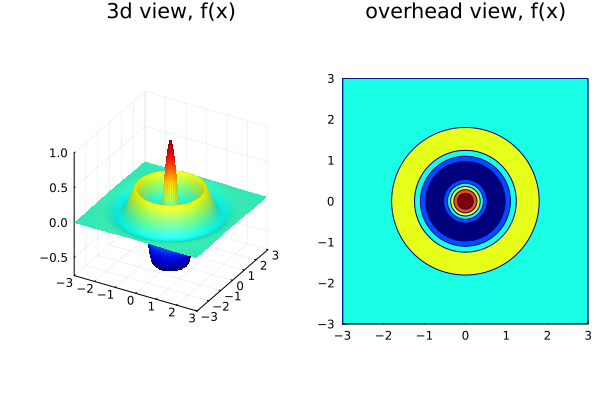

In [17]:
Xorigin = [0 0; 0 0]
a = 0.5
k = 4

r = 3
# make vectors of gridpoints for x1 (x coordinate) and x2 (y coordinate)
x1grid = range(-r, r, length=100)
x2grid = range(-r, r, length=100)

# evaluate f(x) over the 2d grid and store in a matrix
zgrid = [f([x1;x2], Xorigin, a, k) for x2 in x2grid, x1 in x1grid]

# set som plotting parameters
r = 3      # scale of plot: -r < x < r, -r < y < r, 
levels = 5 # number of colorlevels
colormap = :jet

zscale = maximum(abs.(zgrid))  # maximum abs val of f(x) over plane

surface(x1grid, x2grid, zgrid/zscale, seriescolor=colormap, legend=:none)
p1 = plot!(xlim=(-r,r), ylim=(-r,r), aspect_ratio=1, title="3d view, f(x)")

contourf(x1grid, x2grid, zgrid/zscale, color=colormap, levels=levels, legend=:none)
p2 = plot!(legend=:none, xlim=(-r,r), ylim=(-r,r), aspect_ratio=1, title="overhead view, f(x)")

plot(p1,p2)

**Activity:** Play around with the parameters $a,k$ in the above plot to see how they affect the  cicular pattern centered on each data point. 

In general, what the general form 
\begin{align*}
f(x) = \sum_{j=1}^n \cos(k\|x-x_j\|) \; e^{-a \|x-x_j\|^2}
\end{align*}
does is to plop one of these circular patterns on each data point $x_j$ and add them up. They add up like waves, sometime adding up and sometimes canceling, to make the colored patterns below. 

 ## Generate some random patterns!
 
 The following code will generate random patterns based on a few parameters
 
   * $n$ specificies the symmetry group $D_n$, the symmety group of the $n$-gon
   * $N$ specifies the number of random data points on the plane
   * $a$ specifies the scale of the blobs over each data point: large $a$ means narrower blobs
   * $k$ specifies the scale of the oscillation in each blob: large $k$ means more rapid wiggles
   * $s$ specifies the scale of the random data points: large $s$ spreads the points out further in the plane
   * *flip* specifies whether or not to include reflections (flips) in the symmetry group
   
Every time you execute this cell, it'll generate a new pattern based on a new set of random data points. 

Experiment with different choices of parameters, generate the coolest patterns you can!


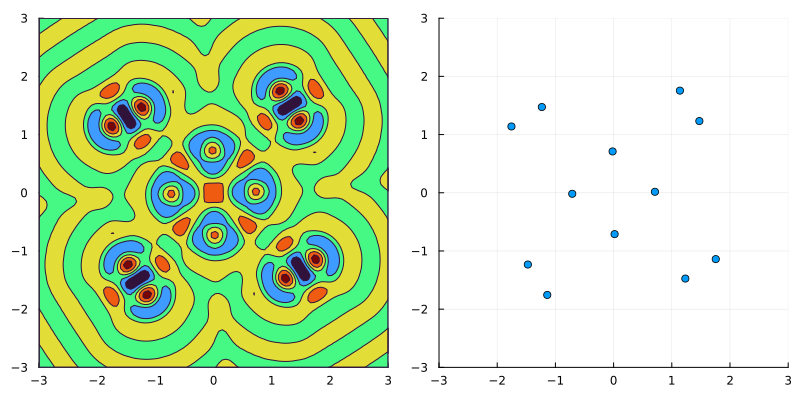

In [128]:
# pattern parameters
n = 4   # n-gon dihedral group
N = 3   # number of random points
a = 2   # scale of blobs (larger a, narrower blobs)
k = 10   # scale of wiggles (larger k, more rapid wiggles)
s = 1   # scale of data points (larger s, further spread out)
flip = false # rotations and flips, or just rotations?

# plotting parameters
r = 3   # length scale of plot: -r < x < r, -r < y < r, 
levels = 5 # number of colorlevels
colormap = :turbo

G = dihedralgroup(n, flip)

X = s*randn(2,N)
#X = fill(0.0, 2,1)
Xsymm = symmetrize(X,G)

x1grid = range(-r, r, length=100)
x2grid = range(-r, r, length=100)

zgrid = [f([x1;x2], Xsymm, a, k) for x2 in x2grid, x1 in x1grid]
zscale = maximum(abs.(zgrid))

contourf(x1grid, x2grid, zgrid/zscale, color=colormap, levels=levels, legend=:none)
p1 = plot!(legend=:none, xlim=(-r,r), clim=(-1,1), ylim=(-r,r), aspect_ratio=1)

p2 = scatter(Xsymm[1,:], Xsymm[2,:], xlim=(-r,r), ylim=(-r,r), label="", aspect_ratio=1)
plot(p1,p2, size=(800,400))

**Activity:** Play around with the pattern parameters $n, N, a, k, s,$ and `flip`.
See what cool plots you can generate! What combination of parameters gives the 
most interesting patterns?